In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve,
    confusion_matrix, classification_report, average_precision_score
)

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)
sns.set_style('whitegrid')

# Random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 1. Data Loading

In [2]:
df_train, df_test = pd.read_csv('../data/processed_train_features.csv'), pd.read_csv('../data/processed_test_features.csv')

In [3]:
id_col = 'job_id'
target_col = 'fraudulent'

X_train = df_train.drop(columns=[id_col, target_col])
y_train = df_train[target_col]

X_test = df_test.drop(columns=[id_col, target_col])
y_test = df_test[target_col]

In [4]:
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [5]:
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    X_train_encoded[col] = le.fit_transform(X_train_encoded[col].astype(str))
    test_values = X_test_encoded[col].astype(str)
    # map unseen categories to a new label
    X_test_encoded[col] = test_values.map(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
    label_encoders[col] = le

print(f"Encoded training shape: {X_train_encoded.shape}")
print(f"Encoded test shape: {X_test_encoded.shape}")

Encoded training shape: (14045, 2070)
Encoded test shape: (3561, 2070)


## 2. Baseline Model Evaluation

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

In [7]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=RANDOM_STATE, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(n_estimators=100, random_state=RANDOM_STATE, verbose=-1)
}

def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    results = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba),
        'avg_precision': average_precision_score(y_test, y_pred_proba)
    }
    return results, y_pred, y_pred_proba

baseline_results = {}
baseline_predictions = {}

print("Evaluating baseline models...\n")
for name, model in tqdm(models.items()):
    print(f"{name}:")
    results, y_pred, y_pred_proba = evaluate_model(model, X_train_scaled, y_train, X_test_scaled, y_test)
    baseline_results[name] = results
    baseline_predictions[name] = {'pred': y_pred, 'proba': y_pred_proba}
    print(f"  Accuracy: {results['accuracy']:.4f}")
    print(f"  Precision: {results['precision']:.4f}")
    print(f"  Recall: {results['recall']:.4f}")
    print(f"  F1-Score: {results['f1']:.4f}")
    print(f"  ROC-AUC: {results['roc_auc']:.4f}")
    print(f"  Avg Precision: {results['avg_precision']:.4f}\n")

Evaluating baseline models...



  0%|          | 0/4 [00:00<?, ?it/s]

Logistic Regression:


 25%|██▌       | 1/4 [00:00<00:01,  2.27it/s]

  Accuracy: 0.9815
  Precision: 0.8286
  Recall: 0.8011
  F1-Score: 0.8146
  ROC-AUC: 0.9796
  Avg Precision: 0.8751

Random Forest:


 50%|█████     | 2/4 [00:08<00:09,  4.94s/it]

  Accuracy: 0.9778
  Precision: 1.0000
  Recall: 0.5635
  F1-Score: 0.7208
  ROC-AUC: 0.9898
  Avg Precision: 0.9091

XGBoost:


 75%|███████▌  | 3/4 [00:17<00:06,  6.92s/it]

  Accuracy: 0.9820
  Precision: 0.9333
  Recall: 0.6961
  F1-Score: 0.7975
  ROC-AUC: 0.9823
  Avg Precision: 0.8968

LightGBM:


100%|██████████| 4/4 [00:25<00:00,  6.29s/it]

  Accuracy: 0.9832
  Precision: 0.9690
  Recall: 0.6906
  F1-Score: 0.8065
  ROC-AUC: 0.9918
  Avg Precision: 0.9199



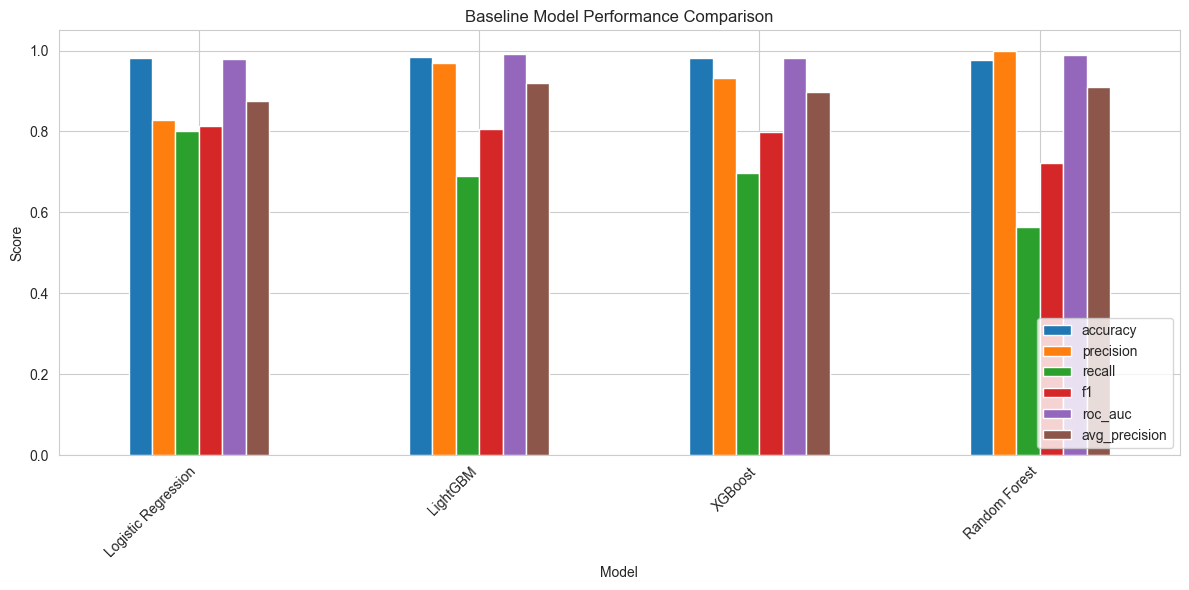


Baseline Model Rankings (by F1-Score):
                        f1  precision  recall  roc_auc
Logistic Regression 0.8146     0.8286  0.8011   0.9796
LightGBM            0.8065     0.9690  0.6906   0.9918
XGBoost             0.7975     0.9333  0.6961   0.9823
Random Forest       0.7208     1.0000  0.5635   0.9898


In [8]:
baseline_df = pd.DataFrame(baseline_results).T
baseline_df = baseline_df.sort_values('f1', ascending=False)

fig, ax = plt.subplots(figsize=(12, 6))
baseline_df.plot(kind='bar', ax=ax)
ax.set_title('Baseline Model Performance Comparison')
ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.legend(loc='lower right')
ax.set_xticklabels(baseline_df.index, rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\nBaseline Model Rankings (by F1-Score):")
print(baseline_df[['f1', 'precision', 'recall', 'roc_auc']])

## 3. Class Imbalance Handling

In [9]:
sampling_techniques = {
    'SMOTE': SMOTE(random_state=RANDOM_STATE),
    'ADASYN': ADASYN(random_state=RANDOM_STATE),
    'Random Undersampling': RandomUnderSampler(random_state=RANDOM_STATE),
    'SMOTE + Tomek': SMOTETomek(random_state=RANDOM_STATE)
}

imbalance_results = {}

for technique_name, sampler in sampling_techniques.items():
    print(f"\nApplying {technique_name}...")
    X_resampled, y_resampled = sampler.fit_resample(X_train_scaled, y_train)
    print(f"  Resampled shape: {X_resampled.shape}")
    print(f"  Class distribution: {pd.Series(y_resampled).value_counts().to_dict()}")
    
    technique_results = {}
    for model_name, model in models.items():
        results, y_pred, y_pred_proba = evaluate_model(model, X_resampled, y_resampled, X_test_scaled, y_test)
        technique_results[model_name] = results
    
    imbalance_results[technique_name] = technique_results


Applying SMOTE...
  Resampled shape: (26766, 2070)
  Class distribution: {0: 13383, 1: 13383}

Applying ADASYN...
  Resampled shape: (26751, 2070)
  Class distribution: {0: 13383, 1: 13368}

Applying Random Undersampling...
  Resampled shape: (1324, 2070)
  Class distribution: {0: 662, 1: 662}

Applying SMOTE + Tomek...
  Resampled shape: (26766, 2070)
  Class distribution: {0: 13383, 1: 13383}



Top 10 Model + Sampling Technique Combinations (by F1-Score):
                                        f1  precision  recall  roc_auc
SMOTE + XGBoost                     0.8310     0.8333  0.8287   0.9840
SMOTE + Tomek + XGBoost             0.8310     0.8333  0.8287   0.9840
ADASYN + XGBoost                    0.8242     0.8614  0.7901   0.9866
SMOTE + LightGBM                    0.8134     0.8202  0.8066   0.9900
SMOTE + Tomek + LightGBM            0.8134     0.8202  0.8066   0.9900
ADASYN + LightGBM                   0.8078     0.8146  0.8011   0.9886
SMOTE + Random Forest               0.7988     0.8599  0.7459   0.9885
SMOTE + Tomek + Random Forest       0.7988     0.8599  0.7459   0.9885
SMOTE + Logistic Regression         0.7885     0.7475  0.8343   0.9741
SMOTE + Tomek + Logistic Regression 0.7885     0.7475  0.8343   0.9741


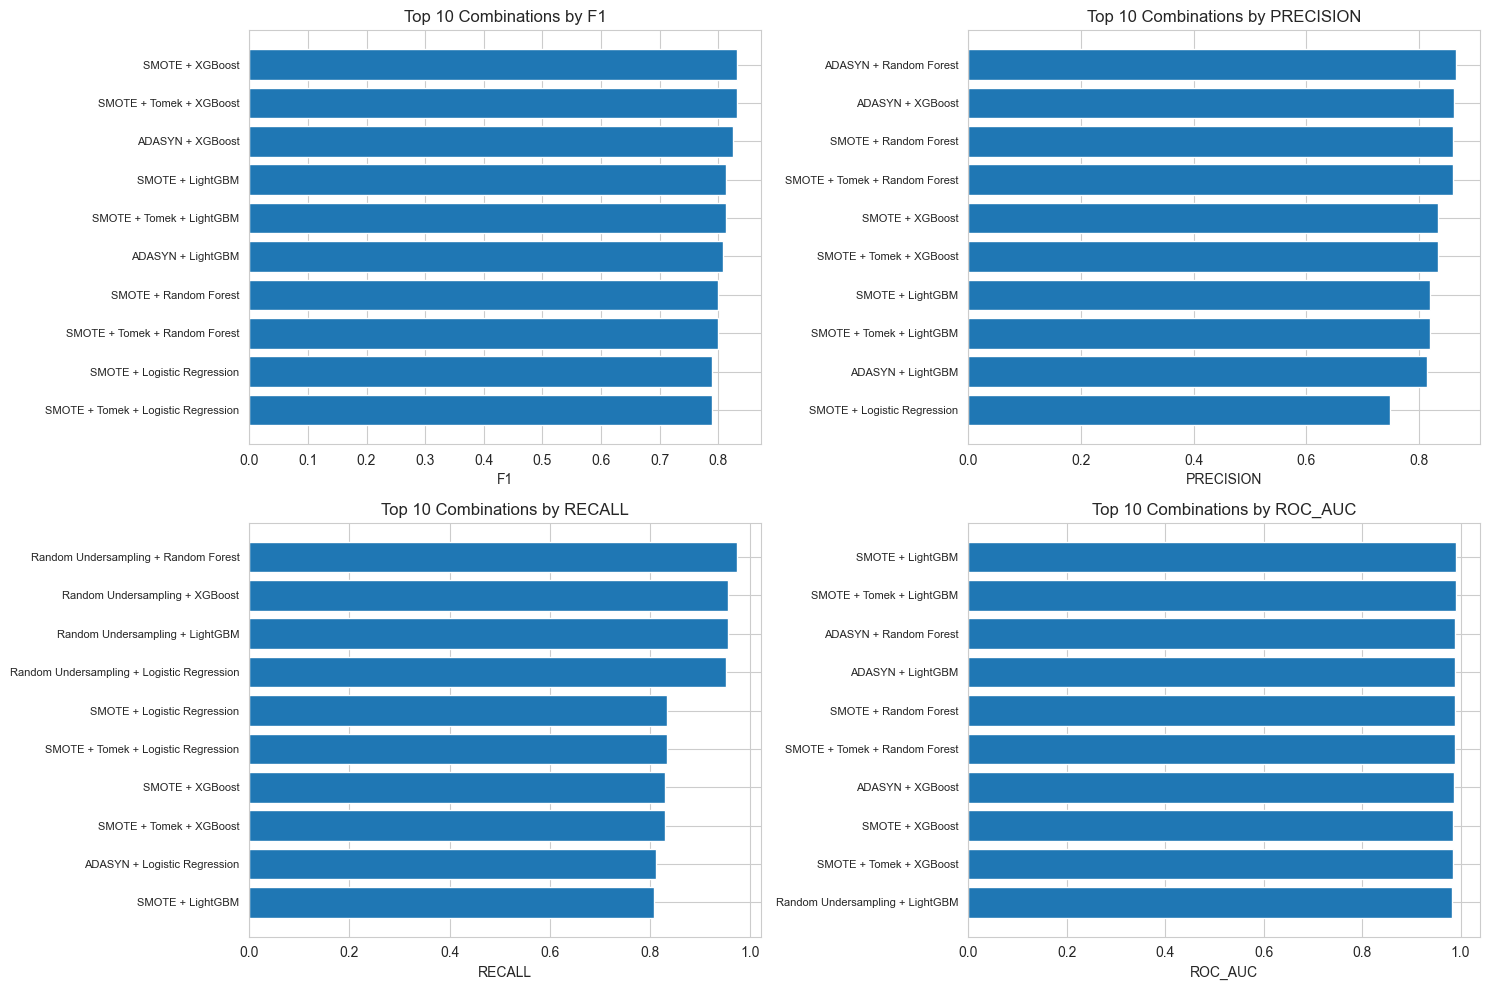

In [ ]:
best_combo = {}
for technique, models_results in imbalance_results.items():
    for model, metrics in models_results.items():
        combo_name = f"{technique} + {model}"
        best_combo[combo_name] = metrics

best_combo_df = pd.DataFrame(best_combo).T
best_combo_df = best_combo_df.sort_values('f1', ascending=False)

print("Top 10 Model + Sampling Technique Combinations (by F1-Score):")
print(best_combo_df.head(10)[['f1', 'precision', 'recall', 'roc_auc']])

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
metrics = ['f1', 'precision', 'recall', 'roc_auc']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    top_10 = best_combo_df.nlargest(10, metric)
    ax.barh(range(len(top_10)), top_10[metric])
    ax.set_yticks(range(len(top_10)))
    ax.set_yticklabels(top_10.index, fontsize=8)
    ax.invert_yaxis()
    ax.set_xlabel(metric.upper())
    ax.set_title(f'Top 10 Combinations by {metric.upper()}')

plt.tight_layout()
plt.show()

## 4. Detailed Model Evaluation

In [11]:
best_model_name = best_combo_df.index[0]
print(f"Best Model Combination: {best_model_name}")
print(f"F1-Score: {best_combo_df.iloc[0]['f1']:.4f}")

technique_name = best_model_name.split(' + ')[0]
model_name = best_model_name.split(' + ')[1]

sampler = sampling_techniques[technique_name]
X_best_resampled, y_best_resampled = sampler.fit_resample(X_train_scaled, y_train)

best_model = models[model_name]
best_model.fit(X_best_resampled, y_best_resampled)

y_pred_best = best_model.predict(X_test_scaled)
y_pred_proba_best = best_model.predict_proba(X_test_scaled)[:, 1]

Best Model Combination: SMOTE + XGBoost
F1-Score: 0.8310


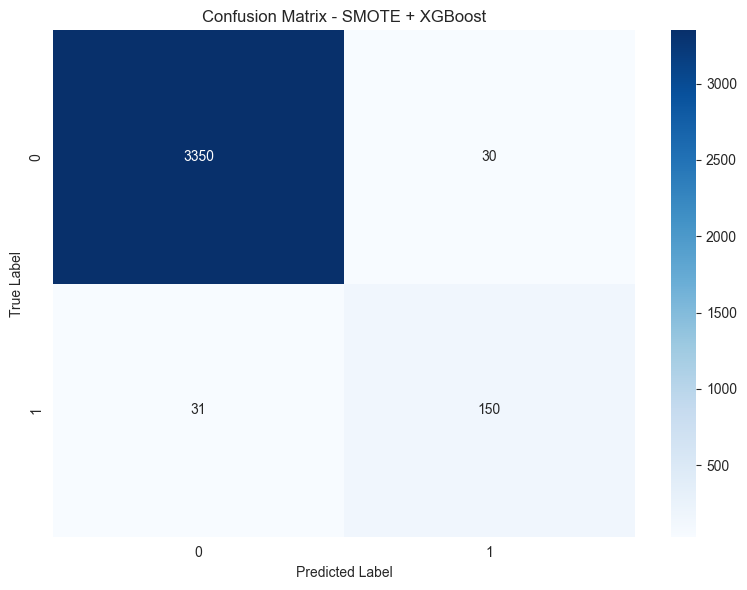

              precision    recall  f1-score   support

  Legitimate       0.99      0.99      0.99      3380
  Fraudulent       0.83      0.83      0.83       181

    accuracy                           0.98      3561
   macro avg       0.91      0.91      0.91      3561
weighted avg       0.98      0.98      0.98      3561



In [12]:
cm = confusion_matrix(y_test, y_pred_best)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title(f'Confusion Matrix - {best_model_name}')
plt.tight_layout()
plt.show()

print(classification_report(y_test, y_pred_best, target_names=['Legitimate', 'Fraudulent']))

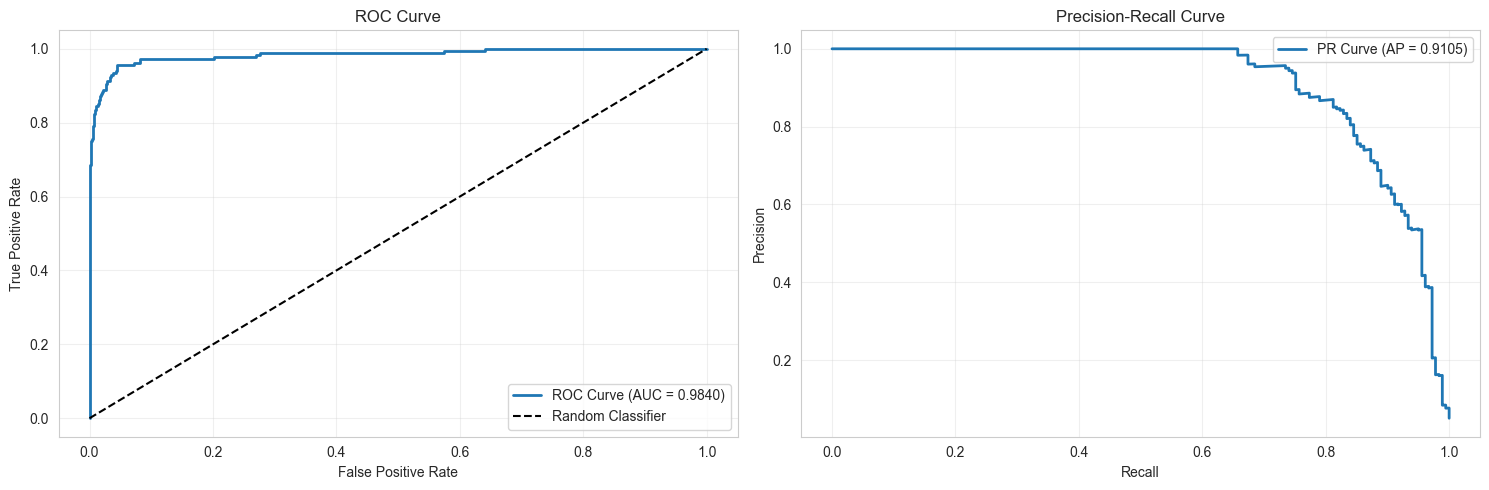

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

fpr, tpr, _ = roc_curve(y_test, y_pred_proba_best)
roc_auc = roc_auc_score(y_test, y_pred_proba_best)

axes[0].plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})', linewidth=2)
axes[0].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_best)
avg_precision = average_precision_score(y_test, y_pred_proba_best)

axes[1].plot(recall, precision, label=f'PR Curve (AP = {avg_precision:.4f})', linewidth=2)
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

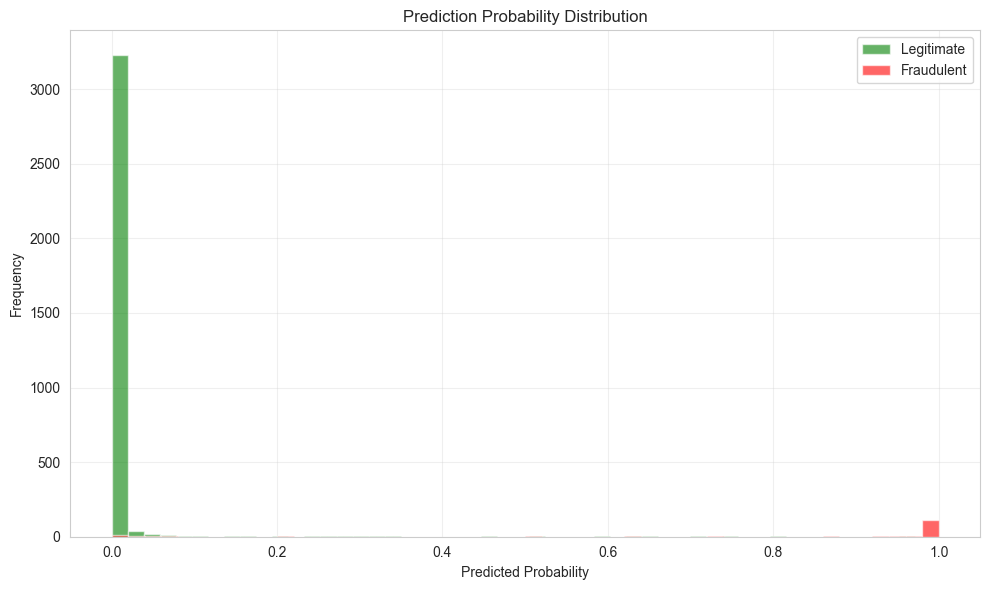

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(y_pred_proba_best[y_test == 0], bins=50, alpha=0.6, label='Legitimate', color='green')
ax.hist(y_pred_proba_best[y_test == 1], bins=50, alpha=0.6, label='Fraudulent', color='red')
ax.set_xlabel('Predicted Probability')
ax.set_ylabel('Frequency')
ax.set_title('Prediction Probability Distribution')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Cross-Validation on Best Model

Cross-Validation Results (5-Fold):
ACCURACY     - Mean: 0.9966 (+/- 0.0017)
PRECISION    - Mean: 0.9936 (+/- 0.0033)
RECALL       - Mean: 0.9996 (+/- 0.0009)
F1           - Mean: 0.9966 (+/- 0.0017)
ROC_AUC      - Mean: 1.0000 (+/- 0.0001)


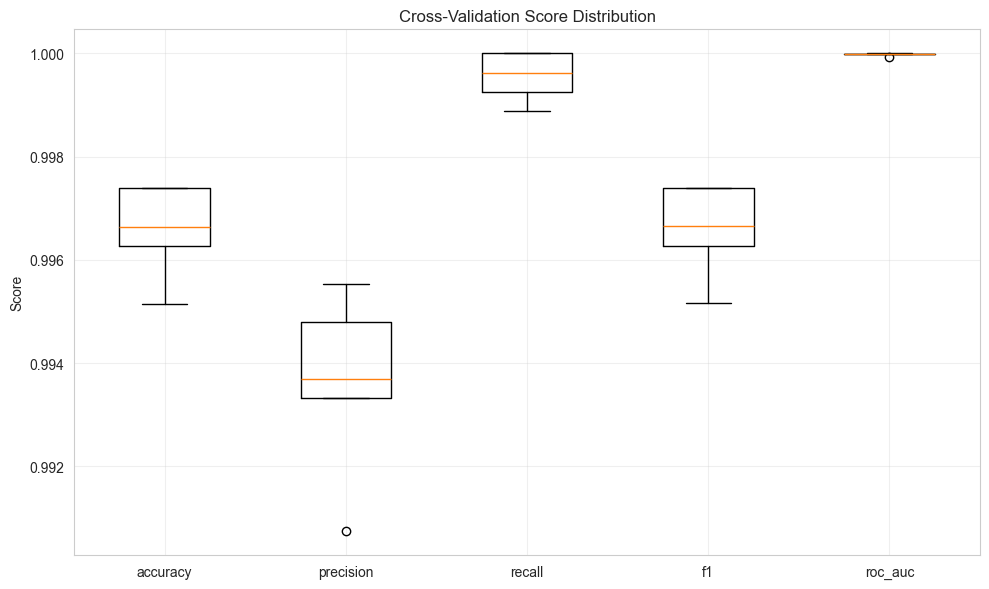

In [15]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_scores = {
    'accuracy': cross_val_score(best_model, X_best_resampled, y_best_resampled, cv=cv, scoring='accuracy'),
    'precision': cross_val_score(best_model, X_best_resampled, y_best_resampled, cv=cv, scoring='precision'),
    'recall': cross_val_score(best_model, X_best_resampled, y_best_resampled, cv=cv, scoring='recall'),
    'f1': cross_val_score(best_model, X_best_resampled, y_best_resampled, cv=cv, scoring='f1'),
    'roc_auc': cross_val_score(best_model, X_best_resampled, y_best_resampled, cv=cv, scoring='roc_auc')
}

print("Cross-Validation Results (5-Fold):")
print("=" * 50)
for metric, scores in cv_scores.items():
    print(f"{metric.upper():12} - Mean: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

fig, ax = plt.subplots(figsize=(10, 6))
positions = range(len(cv_scores))
ax.boxplot(cv_scores.values(), positions=positions, labels=cv_scores.keys())
ax.set_ylabel('Score')
ax.set_title('Cross-Validation Score Distribution')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Summary

In [16]:
print("=" * 80)
print("MODEL EXPLORATION SUMMARY")
print("=" * 80)

print(f"\nDataset Info:")
print(f"  Training samples: {len(X_train)}")
print(f"  Test samples: {len(X_test)}")
print(f"  Number of features: {X_train.shape[1]}")
print(f"  Class imbalance ratio: {y_train.value_counts()[0] / y_train.value_counts()[1]:.2f}:1")

print(f"\nBest Model Configuration:")
print(f"  Model: {model_name}")
print(f"  Sampling Technique: {technique_name}")
print(f"  F1-Score: {best_combo_df.iloc[0]['f1']:.4f}")
print(f"  Precision: {best_combo_df.iloc[0]['precision']:.4f}")
print(f"  Recall: {best_combo_df.iloc[0]['recall']:.4f}")
print(f"  ROC-AUC: {best_combo_df.iloc[0]['roc_auc']:.4f}")

MODEL EXPLORATION SUMMARY

Dataset Info:
  Training samples: 14045
  Test samples: 3561
  Number of features: 2070
  Class imbalance ratio: 20.22:1

Best Model Configuration:
  Model: XGBoost
  Sampling Technique: SMOTE
  F1-Score: 0.8310
  Precision: 0.8333
  Recall: 0.8287
  ROC-AUC: 0.9840
